In [21]:
import pandas;
from sklearn.model_selection import train_test_split;
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler;
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization;
from tensorflow.keras.regularizers import l2, l1_l2;
from tensorflow.keras.utils import plot_model;
from tensorflow.keras.callbacks import EarlyStopping;
from tensorflow.keras.optimizers import Adam;
from tensorflow.keras.metrics import F1Score;
import matplotlib.pyplot as plt;
import numpy;


In [22]:
dataframe = pandas.read_csv("/mnt/d/Code/etc/ml-cua-collection/20240313 - ANN Me/loan_data.csv");

dataframe.head()
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


# Data Initialization

THis step pre-process the whole data by encode the data as step below:

1. Drop na
2. Binary Encode Gender, Self_Employed, Married, Education, and Loan_Status
3. Define whole_feature by disclude Loan_ID, and Loan_Status
4. Define whole_label by including only Loan_Status

Drop Loan_ID and Loan_Status for the whole_feature

In [23]:
dataframe = dataframe.dropna();
dataframe = dataframe.replace({
    "Gender": {"Male":1,"Female" :0},
    "Self_Employed": {"Yes": 1, "No": 0},
    "Married": {"Yes": 1, "No": 0}, 
    "Education": {"Graduate": 1, "Not Graduate": 0}
});


whole_feature = dataframe.drop(columns = ["Loan_ID", "Loan_Status"]);
whole_label = dataframe["Loan_Status"];

feature_train, feature_test, label_train, label_test = train_test_split(whole_feature, whole_label, train_size = 0.7, test_size = 0.3, random_state = 42);
feature_test, feature_val, label_test, label_val = train_test_split(feature_test, label_test, train_size = 0.5, test_size = 0.5, random_state = 42);

feature_train.shape, feature_test.shape, feature_val.shape, label_train.shape, label_test.shape, label_val.shape

((215, 11), (46, 11), (47, 11), (215,), (46,), (47,))

# Data Pre-Processing

1. Perform One-Hot Encoding to Property area and Dependents
2. Standard Scaler all features
3. Perform One-Hot Enconding to all labels

In [24]:
encoder = OneHotEncoder();
columns_to_be_encoded = ["Property_Area", "Dependents"];
encoder.fit(feature_train[columns_to_be_encoded]);

for i, e in enumerate([feature_train, feature_test, feature_val]):

    # Encode the train data first
    encoded_property_area = pandas.DataFrame(
        encoder.transform(e[columns_to_be_encoded]).toarray(),
        columns = encoder.get_feature_names_out()
    );

    e = e.reset_index();
    e = pandas.concat([e, encoded_property_area], axis = 1);

    # Drop the original Property_Area column
    e = e.drop(columns = columns_to_be_encoded);

    if(i == 0):
        feature_train = e;
    elif(i == 1):
        feature_test = e;
    else:
        feature_val = e;


feature_train.head()

,index,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Dependents_0,Dependents_1,Dependents_2,Dependents_3+
0,368,1,1,1,0,2297,1522.0,104.0,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,356,1,1,1,0,3400,2500.0,123.0,360.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,89,1,1,1,0,2698,2034.0,122.0,360.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,19,1,0,0,0,1442,0.0,35.0,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,12,1,1,0,0,4887,0.0,133.0,360.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
# Call out Step 2
scaler = StandardScaler();

feature_train = scaler.fit_transform(feature_train);
feature_test = scaler.transform(feature_test);
feature_val = scaler.transform(feature_val);


In [26]:
# Call out Step 3

label_encoder = OneHotEncoder();

# Convert 1D array to Dataframe
label_train = pandas.DataFrame(label_train, columns = ["Loan_Status"]);

print(label_train.count())

label_encoder.fit(label_train[["Loan_Status"]]);

for i, e in enumerate([label_train, label_test, label_val]):
    if(i != 0):
        e = pandas.DataFrame(e, columns = ["Loan_Status"]);

    encoded_property = pandas.DataFrame(
        label_encoder.transform(e[["Loan_Status"]]).toarray(),
        columns = label_encoder.get_feature_names_out()
    );

    e = pandas.concat([e, encoded_property], axis = 1);
    e = e.drop(columns = ["Loan_Status"]);

    if(i == 0):
        label_train = e;
    if(i == 1):
        label_test = e;
    else:
        label_val = e;

label_train = label_train.dropna();
label_test = label_test.dropna();
label_val = label_val.dropna();

Loan_Status    215
dtype: int64


# Pre-Training data setup

This section will setup all data into float32 numpy array

In [27]:
feature_train = numpy.array(feature_train, dtype = numpy.float32);
feature_test = numpy.array(feature_test, dtype = numpy.float32);
feature_val = numpy.array(feature_val, dtype = numpy.float32);

# Model Architecture

In [28]:
class ANNModel():
    def __init__(self):
        self.input = InputLayer(input_shape = (17,)); # Total input layer is 17

        # Hidden Layer 1
        self.dense1 = Dense(16, activation = "sigmoid", kernel_initializer = "he_normal");
        self.bn1 = BatchNormalization();
        self.dropout1 = Dropout(0.5);

        self.dense2 = Dense(16, activation = "sigmoid", kernel_initializer = "he_normal");
        self.bn2 = BatchNormalization();
        self.dropout2 = Dropout(0.5);


        self.output = Dense(2, activation = "softmax");
    
    # Early stopping after loss are not improved for some epochs
    def _callback_early_stopping(self):
        early_stopping_tolerance = 50;

        return EarlyStopping(
            monitor = "val_loss",
            patience = early_stopping_tolerance,
            restore_best_weights = True
        );

    def forward(self):
        model = Sequential();
        
        # Construct the model
        model.add(self.input);

        model.add(self.dense1);
        model.add(self.dropout1);
        model.add(self.bn1);

        model.add(self.dense2);
        model.add(self.dropout2);
        model.add(self.bn2);

        model.add(self.output);

        plot_model(model, to_file = ("model_architecture.png"), show_shapes = True);
        model.summary();
        self.model = model;

    def fitting(self):
        self.forward();

        model = self.model;

        optimization = Adam(learning_rate = 1e-3);
        
        model.compile(loss = "categorical_crossentropy", optimizer = optimization, metrics = "accuracy");

        history = model.fit(
            feature_train, 
            label_train, 
            epochs = 500, 
            validation_data = (feature_val, label_val), 
            batch_size = 16,
            callbacks = [self._callback_early_stopping()]
        );

        plt.plot(history.history["loss"], label = "Model Training Loss");
        plt.plot(history.history["val_loss"], label = "Model Validation Loss");
        plt.plot(history.history["val_accuracy"], label = "Model Validation Accuracy (binary_accuracy)");
        plt.title("Training and Validation Loss & Accuracy");
        plt.xlabel("Epochs");
        plt.ylabel("Loss (binary_crossentropy)");
        plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5));
        plt.show();

        return model;

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                288       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization_6 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization_7 (Bat  (None, 16)                64        
 chNormalization)                                     

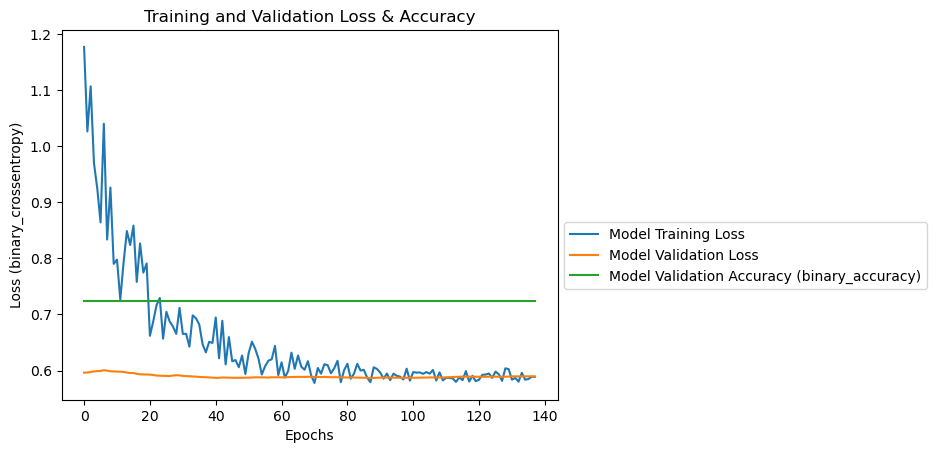

2/2 [==============================] - 0s 9ms/step - loss: 0.6777 - accuracy: 0.6304
Loss:  0.677734375  Accuracy:  0.6304348111152649
2/2 [==============================] - 0s 6ms/step


2024-03-20 20:18:22.538698: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 20:18:22.538817: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 20:18:22.538863: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 20:18:22.539351: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

F1 Score: [0.        0.7733334]


2024-03-20 20:18:22.796814: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 20:18:22.798861: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


In [30]:
ann = ANNModel();

model = ann.fitting();

loss, accuracy = model.evaluate(feature_test, label_test);
print("Loss: ", loss, " Accuracy: ", accuracy);

f1_score = F1Score();
prediction = model.predict(feature_test);
f1 = f1_score.update_state(label_test, prediction);
result = f1_score.result().numpy()

print("F1 Score:", result)
